In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Tuple

1. Design a process that stays in the interval $[a,b]$ and mean-reverts around $\frac{b-a}{с}$, $c \sim \mathcal{U}(a,b)$.

Generate a path and plot it in graph and add the mean line.

solution:

The process has drift μ(x)=θ(c−x), which ensures that the process reverts toward 1/2, 


and the diffusion term σ(x)=σ⋅(x-a)(b−x), which goes to zero at the boundaries x=a and x=b, ensuring that the process remains within [a,b]

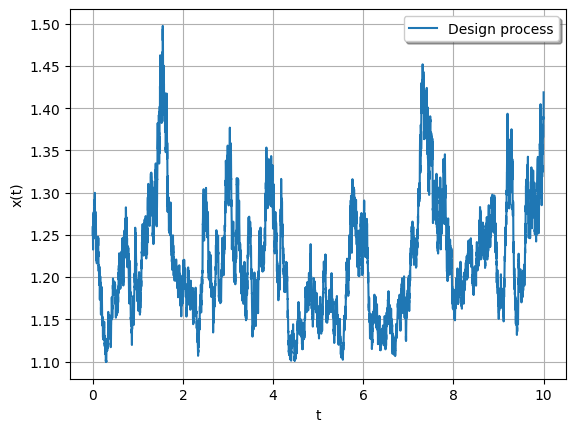

In [158]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1


    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size = self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

class MeanRevertionProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, a=0, b=1, c=2, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * ((b - a) / c - x)
        self.sigmaxt = lambda x: self.params[1] * (x - a) * (b - x)

    def sampler_init_state(self):
        return 0.5 * np.ones(self.Nx)
    

# Parameters
a = 1
b = 6
c = 4

theta = 3.0  # Mean-reversion speed
sigma = 0.2  # Volatility
x0 =  (b - a) / c   # Initial condition (start at [b - a] / c)
Nx = 1
Nt = 10000
T = 10.0 

params = [theta, sigma]

init_state = x0 * np.ones(Nx)

DesProcess = MeanRevertionProcess(params, T, Nx, Nt, a, b, c, init_state)
t_data, x_data = DesProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'Design process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

2. Simulate a Cox-Ingersoll-Ross (CIR) process
$$
dX_t = (6 - 2X_t)dt + θ\sqrt{X_t}dW_t, X(0)=1,
$$
where $θ = θ_1 = 1$ for $t < τ_0 = 0.6$ and $θ = θ_2$ for $t ≥ τ_0$, $t \in (0, 1)$.

Plot the simulated path, plot the shape of statistic $|\hat{D}_k|$ and
identify the change-point $k_0$ on a time-serie and compare result with $\tau_0$.

**Hint (Iacus, 2008, p. 212).** Consider the $\sigma(x)$ is constant and $b(x)$ can be estimated
$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)},
$$
then use residuals
$$
Z_i = \frac{(X_{i+1} - X_i) - \hat{b}(X_i)\Delta_n}{\sqrt{\Delta_n}},
$$
and compute the statistic
$$
\hat{V}_k = \left(\frac{k(n-k)}{n^2}\right)^{1/2} \left(\frac{\hat{S}_{n-k}}{n-k}
- \frac{\hat{S}_k}{k}\right)
 = \frac{\hat{S}_n \hat{D}_k}{\sqrt{n-k}},
$$
where
$\hat{S}_k = \sum_{i=1}^k \hat{Z}_i^2$,
$\hat{S}_{n-k} = \sum_{i=k+1}^n \hat{Z}_i^2$, and $\hat{D}_k = \frac kn - \frac{\hat{S}_k}{\hat{S}_n}.$

Finally the change-point is identifed as the solution to
$$
\hat{k}_0 = \arg \min_k |\hat{D}_k|.
$$

Expected result is:

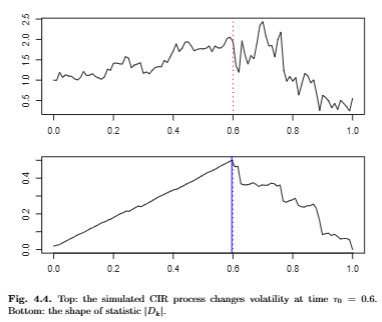

https://forecastegy.com/posts/change-point-detection-time-series-python/

https://github.com/amanahuja/change-detection-tutorial

In [14]:
from scipy.stats import  ncx2
from numba import  njit

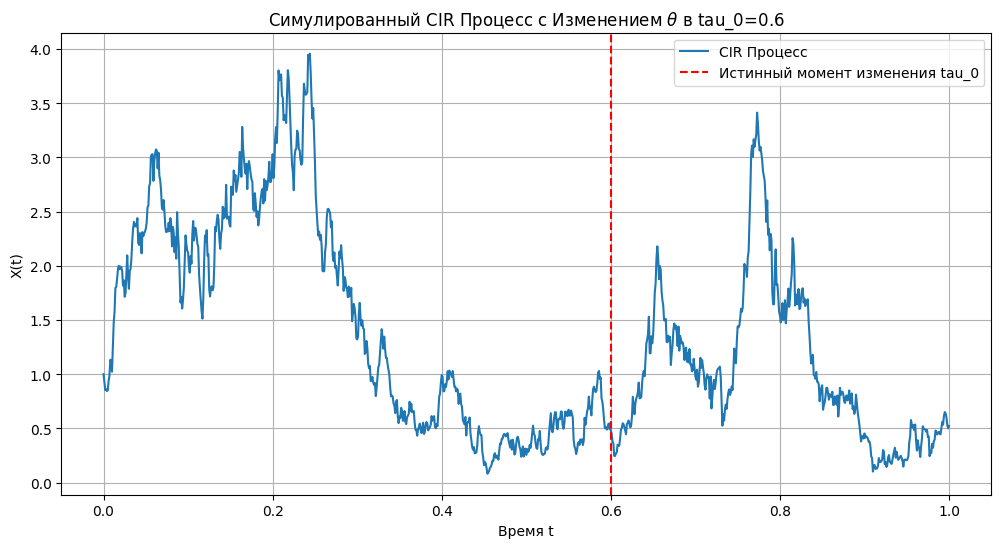

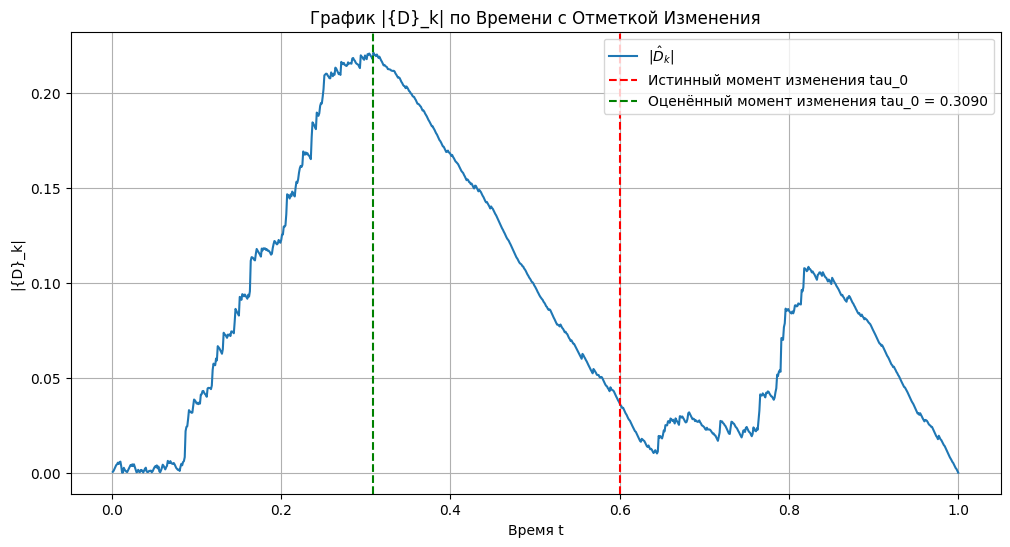

Истинный момент изменения: tau_theta = 0.6
Оценённый момент изменения: y_theta = 0.3090


In [165]:
Nt = 1000
Nx = 100
T = 1.0
t, dt = np.linspace(0, T, Nt+1, retstep=True)
tau = 0.6
theta1 = 1.0
theta2 = 2.0

X = np.zeros(Nt+1)
X[0] = 1.0

dwt = np.sqrt(dt) * np.random.randn(Nt)

for i in range(Nt):
    that = theta1 if t[i] < tau else theta2
    sqrt_Xi = np.sqrt(max(X[i], 0))
    X[i+1] = X[i] + (6 - 2 * X[i]) * dt + theta * sqrt_Xi * dwt[i]
    X[i+1] = max(X[i+1], 0)

plt.figure(figsize=(12, 6))
plt.plot(t, X, label='CIR Процесс')
plt.axvline(x=tau, color='r', linestyle='--', label='Истинный момент изменения tau_0')
plt.xlabel('Время t')
plt.ylabel('X(t)')
plt.title('Симулированный CIR Процесс с Изменением $\\theta$ в tau_0=0.6')
plt.legend()
plt.grid(True)
plt.show()

Z = ((X[1:] - X[:-1]) - (6 - 2 * X[:-1]) * dt) / np.sqrt(dt)

Z_squared = Z**2
S_k = np.cumsum(Z_squared)
S_n = S_k[-1]

k_values = np.arange(1, Nt+1)
D_k = (S_k / S_n) - (k_values / Nt)

plt.figure(figsize=(12, 6))
plt.plot(t[1:], np.abs(D_k), label='$|\\hat{D}_k|$')
plt.axvline(x=tau, color='r', linestyle='--', label='Истинный момент изменения tau_0')

k0 = np.argmax(np.abs(D_k))
t0_estimate = t[k0+1]

plt.axvline(x=t0_estimate, color='g', linestyle='--', label=f'Оценённый момент изменения tau_0 = {t0_estimate:.4f}')
plt.xlabel('Время t')
plt.ylabel('|{D}_k|')
plt.title('График |{D}_k| по Времени с Отметкой Изменения')
plt.legend()
plt.grid(True)
plt.show()

print(f"Истинный момент изменения: tau_theta = {tau}")
print(f"Оценённый момент изменения: y_theta = {t0_estimate:.4f}")

3. Simulate and plot 100 trajectories of the process
$$
dX_t = (0.03tX_t – X^3_t)dt + 0.1dW_t
$$
with the 1st Milstein scheme, $x_0=0$, $t_0=0$, $T=100$, and $\Delta t=0.01$.

Add an average trajectory and confidence interval on the graph.

In [170]:
# your code
class StochasticProcess:
    def __init__(self, T, Nx, Nt, init_state = None):
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = self.DefaultInitState()
        if init_state is not None:
            self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x, t: (0.03 * t * x - x**3) 
        self.sigmaxt = lambda x, t: 0.1
        self.bxt_x = lambda x, t: 0.03 * t - 3 * x **2
        self.bxt_xx = lambda x, t: - 6 * x
        self.sigmaxt_x = lambda x, t: 0
        self.sigmaxt_xx = lambda x, t: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def Milstein1Solution(self):
        dt = self.T / self.Nt
        dwt = dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(self.T/self.Nt)
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1]) * dt + \
                            self.sigmaxt(x_data[i - 1], t_data[i - 1]) * dwt[i - 1] + \
                            1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1]) * \
                            self.sigmaxt_x(x_data[i - 1], t_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

In [176]:
Nx = 100
Nt = 10000

T = 100

init_state = 0.5 * np.ones(Nx)

SProcess = StochasticProcess(T=T, Nx=Nx, Nt=Nt)

t_data, x_data = SProcess.Milstein1Solution()

In [177]:
x_data.mean(axis=1).shape

(10001,)

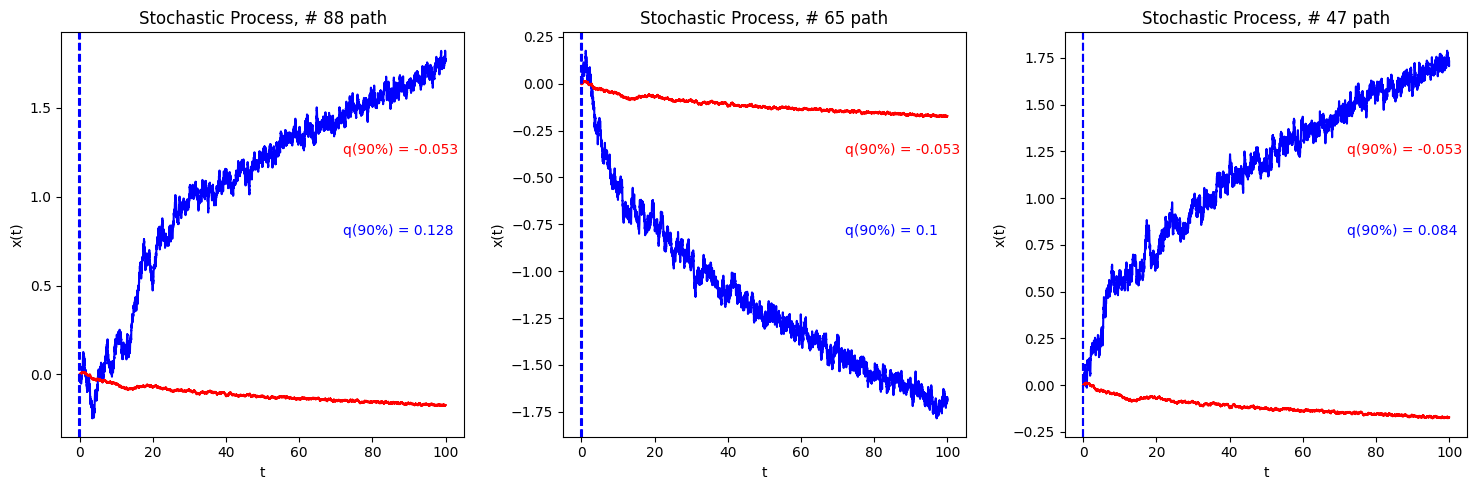

In [178]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

np.random.seed(14)
n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data[:,n], color='blue')
axs[0].plot(t_data, x_data.mean(axis=1), color='red', label = 'Average Path')

val = round(np.quantile(x_data[n], 0.9),3)
axs[0].text(0.7, 0.5, f"q(90%) = {val}", color = 'blue', transform=axs[0].transAxes)
axs[0].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')

val = round(np.quantile(x_data.mean(axis=1), 0.9),3)
axs[0].text(0.7, 0.7, f"q(90%) = {val}", color = 'red', transform=axs[0].transAxes)
axs[0].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')


axs[0].set_title(f'Stochastic Process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

np.random.seed(2001234)
n = np.random.randint(0, Nx)

axs[1].plot(t_data, x_data[:,n], color='blue')
axs[1].plot(t_data, x_data.mean(axis=1), color='red', label = 'Average Path')

val = round(np.quantile(x_data[n], 0.9),3)
axs[1].text(0.7, 0.5, f"q(90%) = {val}", color = 'blue', transform=axs[1].transAxes)
axs[1].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')

val = round(np.quantile(x_data.mean(axis=1), 0.9),3)
axs[1].text(0.7, 0.7, f"q(90%) = {val}", color = 'red', transform=axs[1].transAxes)
axs[1].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')


axs[1].set_title(f'Stochastic Process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

np.random.seed(20241212)
n = np.random.randint(0, Nx)

axs[2].plot(t_data, x_data[:,n], color='blue')
axs[2].plot(t_data, x_data.mean(axis=1), color='red', label = 'Average Path')

val = round(np.quantile(x_data[n], 0.9),3)
axs[2].text(0.7, 0.5, f"q(90%) = {val}", color = 'blue', transform=axs[2].transAxes)
axs[2].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')

val = round(np.quantile(x_data.mean(axis=1), 0.9),3)
axs[2].text(0.7, 0.7, f"q(90%) = {val}", color = 'red', transform=axs[2].transAxes)
axs[2].axvline(x=val, color='blue', linestyle='--', label='90%-Quantile Sample 1')


axs[2].set_title(f'Stochastic Process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

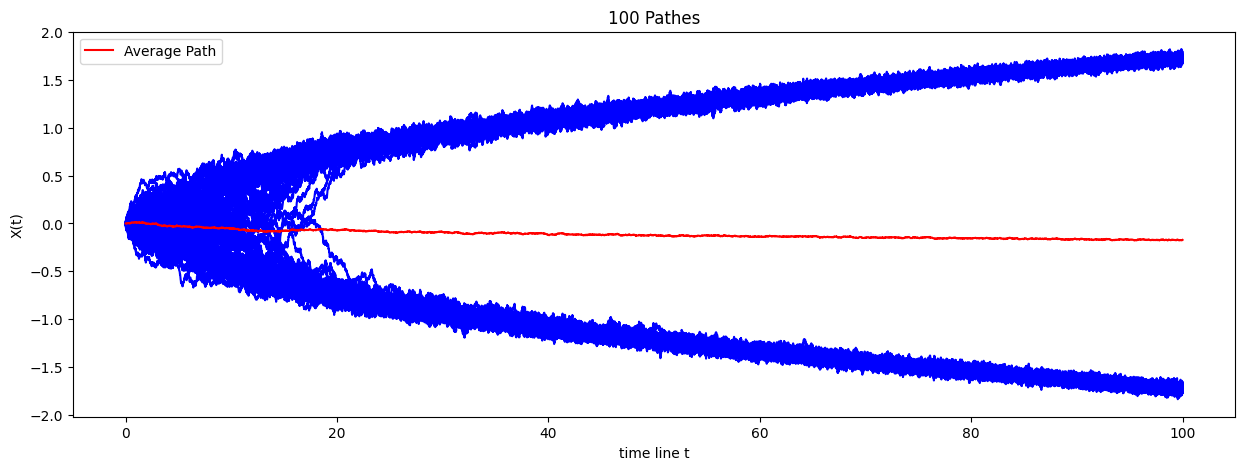

In [180]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))
for i in range(Nx):
    plt.plot(t_data, x_data[:,i], color='blue')

plt.plot(t_data, x_data.mean(axis=1), color='red', label='Average Path')
plt.title('100 Pathes')
plt.xlabel('time line t')
plt.ylabel('X(t)')
plt.legend()

4. Implement a non-parametric drift and diffusion estimators for the Ornstein-Uhlenbeck model
$$
dX_t = (θ_1 - θ_2X_t)dt + θ_3 dW_t,
X(0) = 10,  θ = (0, 3, 2).
$$

Use
*   uniform kernel $K(u) = 1/2$,
*   Epanechnikov (parabolic) kernel $K(u) = \frac{3}{4}(1 - u^2)$,
*   Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$,

and plot the estimations on the graph.


In [228]:
from scipy.optimize import minimize

class OUProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    #Wiener Process by default
    #use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return (params[0] - params[1] * x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * np.ones(len(x))

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return - params[1]

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)
    
    def SimulateProcess(self, dwt=None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = 10 + np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt+1, self.Nx)) * np.sqrt(dt)

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i-1] + (self.params[0]- self.params[1] * x_data[i-1]) * dt + self.params[2] * dwt[i-1]

        return t_data, x_data
    
    def ExactSolution(self, dwt=None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt+1, self.Nx)) * np.sqrt(dt)

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data
    
    def EulerEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.EulerDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

Use
*   uniform kernel $K(u) = 1/2$,
*   Epanechnikov (parabolic) kernel $K(u) = \frac{3}{4}(1 - u^2)$,
*   Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$,

In [229]:
from typing import Literal

def UniformKernel(z):
    return 1/2 * np.ones_like(z)

def EpanechinkovKernel(z):
    return 3/4 * (1 - z**2)

def GaussianKernel(z):
    return 1 / np.sqrt(np.pi * 2) * np.exp(- 0.5 * z ** 2)

kernels = {'uniform': UniformKernel,
           'epanechinkov': EpanechinkovKernel,
           'gaussian': GaussianKernel}

def DiffusionKernelEstimator(x, x_data, delta = None, 
                             method: Literal['uniform', 'epanechinkov', 'gaussian'] = 'uniform'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method not in list(kernels.keys()):
            raise ValueError(f"method = {method} not implemented")
        
        K = kernels[method](z)

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1])**2)
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

def DriftKernelEstimator(x, x_data, delta = None, 
                         method: Literal['uniform', 'epanechinkov', 'gaussian'] = 'uniform'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method not in list(kernels.keys()):
            raise ValueError(f"method = {method} not implemented")
        
        K = kernels[method](z)

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1]))
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

In [230]:
Nx = 1
Nt = 10000

T = 100

x_data = np.linspace(10, 16, 200)

params_OU = [0, 3, 2]

OUp = OUProcess(params_OU, T, Nx, Nt)
# t_data, x_data_OU = OUp.ExactSolution()
t_data, x_data_OU = OUp.SimulateProcess()
# t_data, x_data_OU = OUp.EulerEstimation(np.linspace(0, T, Nt), x_data)

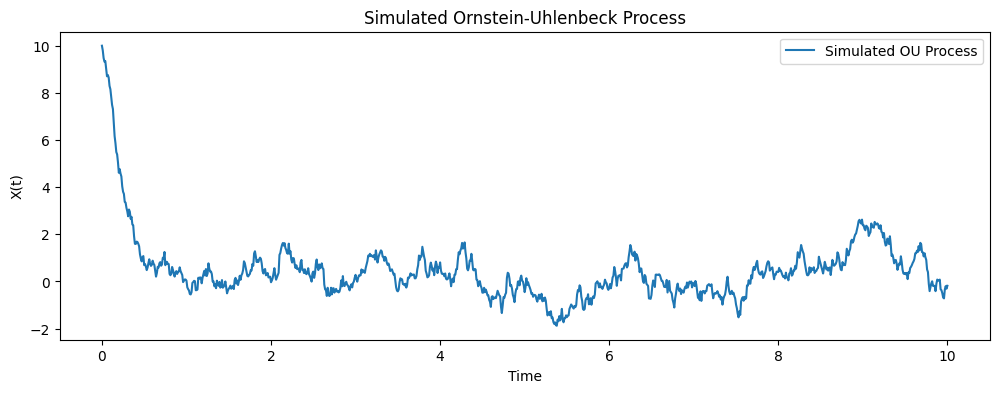

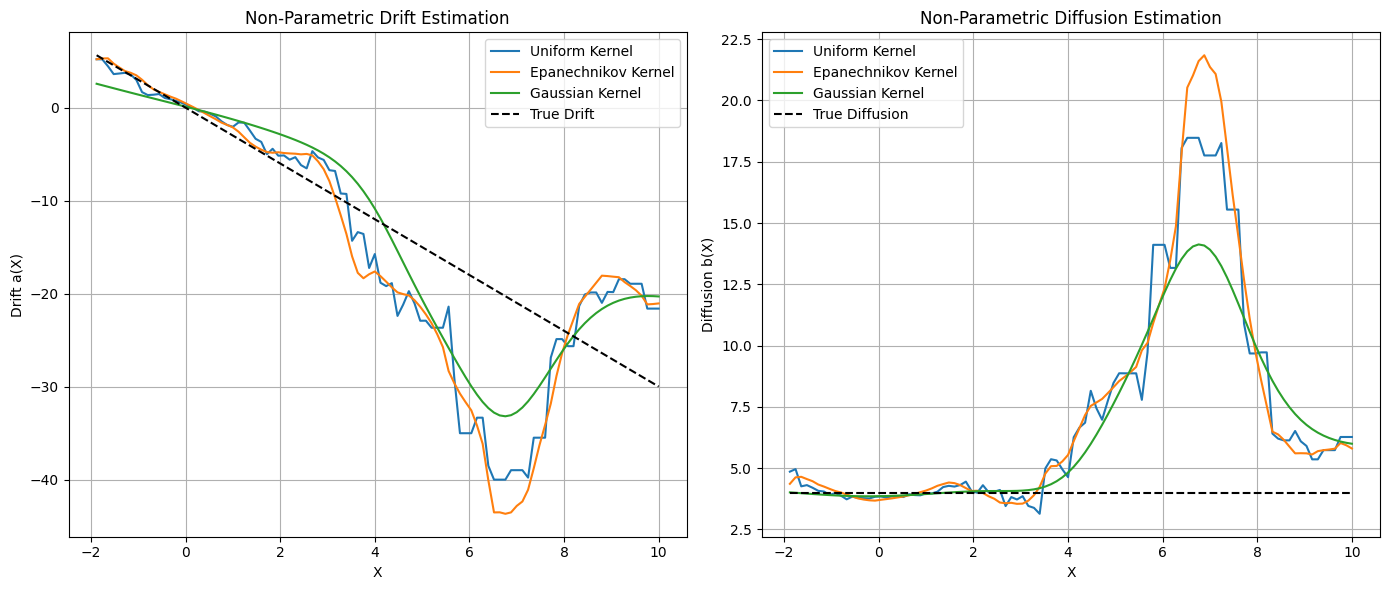

In [235]:
from scipy.stats import norm

np.random.seed(42)

theta1 = 0
theta2 = 3
theta3 = 2
X0 = 10

T = 10
dt = 0.01
N = int(T / dt)
time = np.linspace(0, T, N+1)

X = np.zeros(N+1)
X[0] = X0

for i in range(1, N+1):
    dW = np.sqrt(dt) * np.random.randn()
    X[i] = X[i-1] + (theta1 - theta2 * X[i-1]) * dt + theta3 * dW

plt.figure(figsize=(12, 4))
plt.plot(time, X, label='Simulated OU Process')
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Simulated Ornstein-Uhlenbeck Process')
plt.legend()
plt.show()

def uniform_kernel(u):
    return 0.5 * (np.abs(u) <= 1)

def epanechnikov_kernel(u):
    return (0.75 * (1 - u**2)) * (np.abs(u) <= 1)

def gaussian_kernel(u):
    return norm.pdf(u)

delta_X = X[1:] - X[:-1]

h = 1.0

x_grid = np.linspace(np.min(X), np.max(X), 100)

def kernel_estimation(x_grid, X_prev, delta_X, kernel_func, h):
    a_est = np.zeros_like(x_grid)
    b_est = np.zeros_like(x_grid)
    for idx, x in enumerate(x_grid):
        u = (X_prev - x) / h
        weights = kernel_func(u)
        sum_weights = np.sum(weights)
        if sum_weights > 0:
            a_est[idx] = np.sum(weights * (delta_X / dt)) / sum_weights
            b_est[idx] = np.sum(weights * ((delta_X)**2 / dt)) / sum_weights
        else:
            a_est[idx] = np.nan
            b_est[idx] = np.nan
    return a_est, b_est

X_prev = X[:-1]

kernels = {
    'Uniform': uniform_kernel,
    'Epanechnikov': epanechnikov_kernel,
    'Gaussian': gaussian_kernel
}

a_true = -theta2 * x_grid
b_true = theta3**2 * np.ones_like(x_grid)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for name, kernel in kernels.items():
    a_est, b_est = kernel_estimation(x_grid, X_prev, delta_X, kernel, h)

    axes[0].plot(x_grid, a_est, label=f'{name} Kernel')

    axes[1].plot(x_grid, b_est, label=f'{name} Kernel')

axes[0].plot(x_grid, a_true, 'k--', label='True Drift')
axes[1].plot(x_grid, b_true, 'k--', label='True Diffusion')

axes[0].set_xlabel('X')
axes[0].set_ylabel('Drift a(X)')
axes[0].set_title('Non-Parametric Drift Estimation')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('X')
axes[1].set_ylabel('Diffusion b(X)')
axes[1].set_title('Non-Parametric Diffusion Estimation')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

5. Estimate the parameters of a random process. As candidates use
*   Ornstein-Uhlenbeck process,
*   Geometric Brownian motion process,
*   Cox-Ingersoll-Ross process.

Plot three models in a graph and choose the best one. Provide the proof of your solution.

Time-series (*. csv) in the [folder](https://drive.google.com/drive/folders/1tzHl3-7jMtRiGgFe5suqT2CzftZ0o9cB?usp=sharing).

In [236]:
from pymle.models import GeometricBM, CIR, OrnsteinUhlenbeck
from pymle.core.TransitionDensity import ShojiOzakiDensity, KesslerDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE
from pymle.core.Model import Model1D
from pymle.core.TransitionDensity import TransitionDensity
from typing import Union
from scipy.stats import norm

In [237]:
class CustomOrnsteinUhlenbeck(Model1D):
    """
    Model for OU (ornstein-uhlenbeck):
    Parameters: [kappa, mu, sigma]

    dX(t) = mu(X,t)*dt + sigma(X,t)*dW_t

    where:
        mu(X,t)    = kappa * (mu - X)
        sigma(X,t) = sigma * X
    """

    def __init__(self):
        super().__init__(has_exact_density=True)

    def drift(self, x: Union[float, np.ndarray], t: float) -> Union[float, np.ndarray]:
        return self._params[0] * (self._params[1] - x)

    def diffusion(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        # return self._params[2] * (x > -10000)
        return self._params[2]

    def exact_density(self, x0: float, xt: float, t0: float, dt: float) -> float:
        kappa, theta, sigma = self._params
        mu = theta + (x0 - theta) * np.exp(-kappa * dt)
        # mu = X0*np.exp(-kappa*t) + theta*(1 - np.exp(-kappa*t))
        var = (1 - np.exp(-2 * kappa * dt)) * (sigma * sigma / (2 * kappa))
        return norm.pdf(xt, loc=mu, scale=np.sqrt(var))

    def AitSahalia_density(self, x0: float, xt: float, t0: float, dt: float) -> float:
        kappa, alpha, eta = self._params
        m = 1
        x = xt

        output = (
            (-m / 2) * np.log(2 * np.pi * dt)
            - np.log(eta)
            - ((x - x0) ** 2 / (2 * eta**2)) / dt
            + ((-(x**2 / 2) + x0**2 / 2 + x * alpha - x0 * alpha) * kappa) / eta**2
            - (
                (1 / (6 * eta**2))
                * (
                    kappa
                    * (
                        -3 * eta**2
                        + (
                            x**2
                            + x0**2
                            + x * (x0 - 3 * alpha)
                            - 3 * x0 * alpha
                            + 3 * alpha**2
                        )
                        * kappa
                    )
                )
            )
            * dt
            - (1 / 2) * (kappa**2 / 6) * dt**2
            + (1 / 6)
            * (
                (
                    4 * x**2
                    + 7 * x * x0
                    + 4 * x0**2
                    - 15 * x * alpha
                    - 15 * x0 * alpha
                    + 15 * alpha**2
                )
                * kappa**4
            )
            / (60 * eta**2)
            * dt**3
        )
        return np.exp(output)

    # =======================
    # (Optional) Overrides for numerical derivatives to improve performance
    # =======================

    def drift_t(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        return 0.0
    
    def drift_x(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        return -self._params[0]

    def diffusion_x(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        return 0.0

    def diffusion_xx(
        self, x: Union[float, np.ndarray], t: float
    ) -> Union[float, np.ndarray]:
        return 0.0


In [238]:
# your code
df = pd.read_csv('4.csv')
df.columns = ['time', 'value']

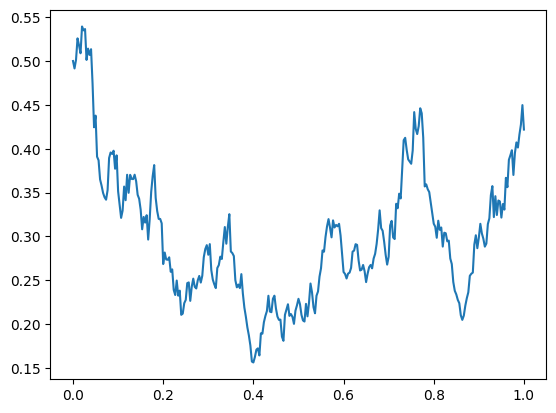

In [239]:
plt.plot(df.time, df.value)
plt.show()

In [240]:
sample = df.value.values

In [241]:
def fit_Kessler(model_name: Literal['CIR', 'GBM', 'OU']):

    models = {'CIR': CIR(),
              'GBM':  GeometricBM(),
              'OU': OrnsteinUhlenbeck()}
    
    if model_name not in list(models.keys()):
        raise ValueError(f'the model {model_name} does not exists\nchoose on from: {list(models.keys())}')

    # Create parametrization templates:
    param_bounds = {'CIR': [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    'GBM': [(0.01, 10), (0.01, 2)],                         # GBM
                    'OU': [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    }

    param_guess  = {'CIR': [0.01, 0.01, 0.2],                               # CIR
                    'GBM': [0.01, 0.2],                                     # GBM
                    'OU': [0.01, 0.01, 0.2],                               # OU
                    }

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1

    # Estimate max likelyhood, using Shoji-Ozaki
    # shoji_ozaki_est = AnalyticalMLE(sample, param_bounds[model_name], dt, density=ShojiOzakiDensity(models[model_name])).estimate_params(param_guess[model_name]).aic
    # shoji_ozaki_params = AnalyticalMLE(sample, param_bounds[model_name], dt, density=ShojiOzakiDensity(models[model_name])).estimate_params(param_guess[model_name]).params

    kessler_est = AnalyticalMLE(sample, param_bounds[model_name], dt, density=KesslerDensity(models[model_name])).estimate_params(param_guess[model_name]).aic
    kessler_params = AnalyticalMLE(sample, param_bounds[model_name], dt, density=KesslerDensity(models[model_name])).estimate_params(param_guess[model_name]).params

    return kessler_est, kessler_params

In [242]:
estimation_ou, params_ou = fit_Kessler('OU')
estimation_gbm, params_gbm = fit_Kessler('GBM')
estimation_cir, params_cir = fit_Kessler('CIR')

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 783.9880016061163
`xtol` termination condition is satisfied.
Number of iterations: 100, function evaluations: 424, CG iterations: 192, optimality: 1.38e-05, constraint violation: 0.00e+00, execution time: 0.12 s.
Final Params: [7.37485525 0.29187946 0.2569455 ]
Final Likelihood: 811.2784772497869
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 783.9880016061163


/Users/hubievkasym/Desktop/Python Projects/SberProject/venv/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 100, function evaluations: 424, CG iterations: 192, optimality: 1.38e-05, constraint violation: 0.00e+00, execution time: 0.098 s.
Final Params: [7.37485525 0.29187946 0.2569455 ]
Final Likelihood: 811.2784772497869
Initial Params: [0.01, 0.2]
Initial Likelihood: -1307.1082597791083
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 93, CG iterations: 47, optimality: 1.19e-01, constraint violation: 0.00e+00, execution time: 0.028 s.
Final Params: [0.24190274 0.850238  ]
Final Likelihood: 820.6781380238136
Initial Params: [0.01, 0.2]
Initial Likelihood: -1307.1082597791083
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 93, CG iterations: 47, optimality: 1.19e-01, constraint violation: 0.00e+00, execution time: 0.03 s.
Final Params: [0.24190274 0.850238  ]
Final Likelihood: 820.6781380238136
Initial Params: [0.01, 0.01, 0.2]
Initial Likeliho

$dS_{t}=\mu S_{t}\,dt+\sigma S_{t}\,dW_{t}$

In [243]:
processes = {}

def CIR_pr(dx, theta1, theta2, theta3, theta4, dt, dw):
    return (theta1 - theta2 * dx) * dt + theta3 * dx ** 0.5 * dw

processes['CIR'] = CIR_pr

def OU_pr(dx, theta1, theta2, theta3, theta4, dt, dw):
    return (theta1 - theta2 * dx) * dt + theta3 * dw

processes['OU'] = OU_pr

def GBM_pr(dx, theta1, theta2, theta3, theta4, dt, dw):
    return theta1 * dx * dt + theta2 * dx * dw

processes['GBM'] = GBM_pr

In [244]:
params_cir

array([6.85846649, 0.29182603, 0.45808336])

Оцененные параметры CIR:
theta = 1.0
mu = 0.30227806773178556
sigma = 0.1
MSE Ornstein-Uhlenbeck: 0.0030970090150419555
MSE Geometric Brownian Motion: 0.06109270534027156
MSE Cox-Ingersoll-Ross: 0.024254408884951024


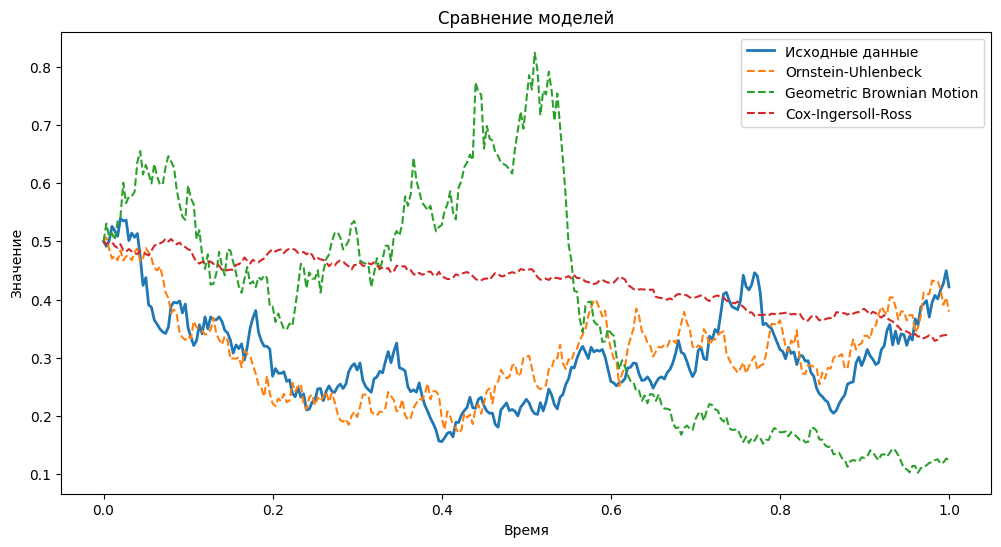

In [248]:
time = df['time'].values
values = df['value'].values
dt = np.diff(time)

def ou_log_likelihood(params, x, dt):
    theta, mu, sigma = params
    n = len(x) - 1
    likelihood = 0
    for i in range(n):
        m = x[i] * np.exp(-theta * dt[i]) + mu * (1 - np.exp(-theta * dt[i]))
        s2 = (sigma**2 / (2 * theta)) * (1 - np.exp(-2 * theta * dt[i]))
        likelihood += -0.5 * np.log(2 * np.pi * s2) - ((x[i+1] - m)**2) / (2 * s2)
    return -likelihood

initial_guess = [1.0, np.mean(values), 0.1]

result_ou = minimize(ou_log_likelihood, initial_guess, args=(values, dt), bounds=((1e-5, None), (None, None), (1e-5, None)))
theta_ou, mu_ou, sigma_ou = result_ou.x

log_returns = np.diff(np.log(values))

mu_gbm = np.mean(log_returns) / np.mean(dt)
sigma_gbm = np.std(log_returns) / np.sqrt(np.mean(dt))


def cir_method_of_moments(x, dt):
    X_t = x[:-1]
    X_tp = x[1:]
    mean_X_t = np.mean(X_t)
    mean_X_tp = np.mean(X_tp)
    var_X_tp = np.var(X_tp)

    def moments_error(params):
        theta, mu, sigma = params
        if theta <= 0 or mu <= 0 or sigma <= 0:
            return np.inf
        E_X_tp = mean_X_t * np.exp(-theta * dt.mean()) + mu * (1 - np.exp(-theta * dt.mean()))
        Var_X_tp = (sigma**2 * mean_X_t) / (2 * theta) * (1 - np.exp(-2 * theta * dt.mean()))
        error1 = (E_X_tp - mean_X_tp)**2
        error2 = (Var_X_tp - var_X_tp)**2
        return error1 + error2

    initial_guess = [1.0, np.mean(values), 0.1]
    result = minimize(moments_error, initial_guess, bounds=((1e-5, None), (1e-5, None), (1e-5, None)))
    if result.success:
        theta, mu, sigma = result.x
        return theta, mu, sigma
    else:
        raise RuntimeError("Оптимизация не сошлась для метода моментов.")

theta_cir, mu_cir, sigma_cir = cir_method_of_moments(values, dt)
print(f"Оцененные параметры CIR:\ntheta = {theta_cir}\nmu = {mu_cir}\nsigma = {sigma_cir}")

def simulate_cir(theta, mu, sigma, x0, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        mean = x[i-1] * np.exp(-theta * dt[i-1]) + mu * (1 - np.exp(-theta * dt[i-1]))
        variance = (sigma**2 * x[i-1] / (2 * theta)) * (1 - np.exp(-2 * theta * dt[i-1]))
        x[i] = mean + np.sqrt(variance) * np.random.normal()
        x[i] = max(x[i], 0)
    return x

np.random.seed(123)
cir_sim = simulate_cir(theta_cir, mu_cir, sigma_cir, values[0], dt, len(values))

def simulate_ou(theta, mu, sigma, x0, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = x[i-1] + theta * (mu - x[i-1]) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal()
    return x

ou_sim = simulate_ou(theta_ou, mu_ou, sigma_ou, values[0], dt, len(values))

def simulate_gbm(mu, sigma, x0, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = x[i-1] * np.exp((mu - 0.5 * sigma**2) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal())
    return x

gbm_sim = simulate_gbm(mu_gbm, sigma_gbm, values[0], dt, len(values))

mse_ou = np.mean((values - ou_sim)**2)
mse_gbm = np.mean((values - gbm_sim)**2)
mse_cir = np.mean((values - cir_sim)**2)

print(f"MSE Ornstein-Uhlenbeck: {mse_ou}")
print(f"MSE Geometric Brownian Motion: {mse_gbm}")
print(f"MSE Cox-Ingersoll-Ross: {mse_cir}")

plt.figure(figsize=(12, 6))
plt.plot(time, values, label='Исходные данные', linewidth=2)
plt.plot(time, ou_sim, label='Ornstein-Uhlenbeck', linestyle='--')
plt.plot(time, gbm_sim, label='Geometric Brownian Motion', linestyle='--')
plt.plot(time, cir_sim, label='Cox-Ingersoll-Ross', linestyle='--')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Сравнение моделей')
plt.legend()
plt.show()